In [1]:
import torch
import torchvision
from numpy import vstack
from numpy import argmax
import pandas as pd
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import BCELoss
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_

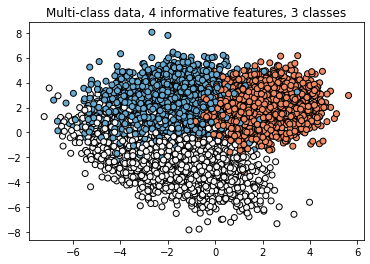

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
plt.title("Multi-class data, 4 informative features, 3 classes", fontsize="large")


X, y = make_classification(n_samples=10000, n_features=5, n_informative=5,
                           n_redundant=0, n_repeated=0, n_classes=3,
                           n_clusters_per_class=1,
                           weights=[0.33, 0.33, 0.33],
                           class_sep=2, random_state=0)

import matplotlib.pyplot as plt
colors = ['#ef8a62' if v == 0 else '#f7f7f7' if v == 1 else '#67a9cf' for v in y]
kwarg_params = {'linewidth': 1, 'edgecolor': 'black'}
plt.scatter(X[:, 0], X[:, 1], c=colors, **kwarg_params)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((6700, 5), (3300, 5), (6700,), (3300,))

In [5]:
X_train = X.reshape(-1, X.shape[1]).astype('float32')
Y_train = y

X_test = X_test.reshape(-1, X_test.shape[1]).astype('float32')
Y_test = Y_test

In [6]:
import torch
Y_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(np.asarray(Y_test))

In [7]:
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self):
    
        # store the inputs and outputs
        self.X = torch.from_numpy(X_train)
        self.y = torch.from_numpy(Y_train)
        self.len=self.X.shape[0]
        # ensure input data is floats
#         self.X = self.X.astype('float32')
        # label encode target and ensure the values are floats
        self.y = LabelEncoder().fit_transform(self.y)
#         self.y = self.y.astype('float32') 
 
    # number of rows in the dataset
    def __len__(self):
        return self.len
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.30):
        # determine sizes
        test_size = round(n_test * self.len)
        train_size = self.len - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])
 

In [8]:
data=CSVDataset()

In [9]:
print(data.X[0:5])
print(data.X.shape)
print(data.y[0:5])
print(data.y.shape)

tensor([[ 2.7961,  3.1249,  1.2221, -2.1737, -0.1023],
        [ 0.6262,  1.7929,  1.7365, -1.6445, -0.6758],
        [-2.2186,  0.2158,  1.6987,  0.3031, -0.2728],
        [ 2.3306,  3.8660,  3.5224, -0.4996, -2.4737],
        [-1.4999, -2.5950,  1.5148,  0.7543,  4.8789]])
torch.Size([10000, 5])
[0 0 2 0 1]
(10000,)


In [10]:
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 64)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='sigmoid')
        self.act1 = Sigmoid()
        # second hidden layer
        self.hidden2 = Linear(64,32)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='sigmoid')
        self.act2 = Sigmoid()
        # third hidden layer
        self.hidden3 = Linear(32,8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act3 = ReLU()
        # forth hidden layer and output
        self.hidden4 = Linear(8, 3)
        xavier_uniform_(self.hidden3.weight)
        self.act4 = Softmax(dim=1)
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer
        X = self.hidden3(X)
        X = self.act3(X)
        # output layer
        X = self.hidden4(X)
        X = self.act4(X)
        return X
    

In [11]:
num_epochs = 100
train_accu=[]
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.8)
    loss_vals=  []
    correct=0
    total=0
    # enumerate epochs
    for epoch in range(num_epochs):
        epoch_loss= []
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            outputs=model(inputs)
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            epoch_loss.append(loss.item())
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        loss_vals.append(loss.item())
        accu=100.*correct/total
        train_accu.append(accu)
    return loss_vals

In [12]:
# prepare the dataset
def prepare_data():
    # load the dataset
    dataset = CSVDataset()
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train, batch_size=10, shuffle=True)
    test_dl = DataLoader(test, batch_size=10, shuffle=False)
    return train_dl, test_dl

In [13]:
# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [14]:
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [15]:
# prepare data
train_dl, test_dl = prepare_data()
print(len(train_dl.dataset), len(test_dl.dataset))
# define the network
model = MLP(5)

7000 3000


In [16]:
# train the model
trained_model = train_model(train_dl, model)

In [17]:
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.961


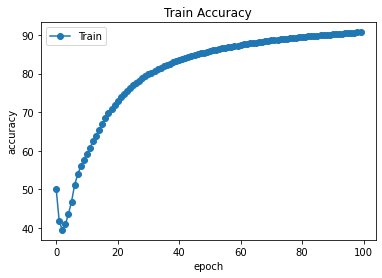

In [18]:
#plot accuracy

plt.plot(train_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train'])
plt.title('Train Accuracy')

plt.show()